# **Técnicas Avanzadas de Aprendizaje**

##*Gradient Boosting* - Estimación de precios de inmuebles##

###Andrea Azábal Lamoso###

28 de junio de 2021

---

# Preparación del entorno

Importamos los paquetes necesarios:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import re
import matplotlib.pyplot as plt

# *Dataset*

Disponemos de un *dataset* con información de inmuebles vendidos en el Condado de King, incluida la ciudad de Seattle, entre mayo de 2014 y mayo de 2015.

El objetivo de la práctica consiste en utilizar algoritmos vistos en el módulo para la estimación de los precios de venta de inmuebles en este condado y para esas fechas.

Las variables son las siguientes: 

- Id: identificador del inmueble. 
- Date: fecha de venta en formato “YYYYMMDDT000000”. 
- Price: precio de venta final en $. 
- Bedrooms: número de habitaciones del inmueble. 
- Bathrooms: número de aseos del inmueble. 
- Sqft_living: área del inmueble en pies cuadrados. 
- Sqft_lot: área de la parcela en la que se encuentra. 
- Floors: número de pisos del inmueble. 
- Waterfront: valor = 0 si no tiene vistas al mar; valor = 1 si tiene vistas al mar. 
- View: nos dice si ha sido visitada por potenciales compradores muchas o pocas veces (0 pocas, 4 muchas). 
- Condition: condición en la que se encuentra el inmueble (1 mal, 5 muy bien). 
- Grade: calificación dada al inmueble, basada en un sistema propio del Condado de King (cuanto mayor es el valor, mejor es el inmueble). 
- Sqft_above: área en pies cuadrados del inmueble si no contamos el sótano. 
- Sqft_basement: área en pies cuadrados del sótano. 
- Yr_built: año de construcción. 
- Yr_renovated: año en que fue reformado/restaurado. 
- Zipcode: parecido al código postal español. 
- Lat: latitud en grados. 
- Lon: longitud en grados. 
- Sqft_living: área media de los 15 inmuebles vecinos más cercanos. 
- Sqft_lot15: área media de las 15 parcelas vecinas más cercanas. 




Importamos el fichero .csv:

In [2]:
from google.colab import files

uploaded = files.upload()

Saving act4_kc_house_data.csv to act4_kc_house_data.csv


Almacenamos los datos contenidos en el csv en un *dataframe*:

In [3]:
path = "/content/act4_kc_house_data.csv"
df_ini = pd.read_csv(path, sep=",", parse_dates=["date"])
print (df_ini.shape)
df_ini.head(3)


(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


Se tienen 21 variables en total, 15 de tipo entero, 5 de tipo *float*  y una fecha:

In [4]:
df_ini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

En primer lugar, vamos a transformar las áreas almacenadas en pies cuadrados a metros cuadrados. Además, vamos a deshacernos del identificador de cada inmueble, ya que es una variable nominal que no aporta mayor información.

In [5]:
# Creamos nuevo df
df=df_ini[['price', 'date', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long']].copy()

# Conversion superficies
conv_rate=10.763910417 #ratio de conversion ft2 a m2
df['m2_living']=round(df_ini['sqft_living']/conv_rate,2)
df['m2_lot']=round(df_ini['sqft_lot']/conv_rate,2)
df['m2_above']=round(df_ini['sqft_above']/conv_rate,2)
df['m2_basement']=round(df_ini['sqft_basement']/conv_rate,2)
df['m2_living15']=round(df_ini['sqft_living15']/conv_rate,2)
df['m2_lot15']=round(df_ini['sqft_lot15']/conv_rate,2)

# Resumen nuevo df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         21613 non-null  float64       
 1   date          21613 non-null  datetime64[ns]
 2   bedrooms      21613 non-null  int64         
 3   bathrooms     21613 non-null  float64       
 4   floors        21613 non-null  float64       
 5   waterfront    21613 non-null  int64         
 6   view          21613 non-null  int64         
 7   condition     21613 non-null  int64         
 8   grade         21613 non-null  int64         
 9   yr_built      21613 non-null  int64         
 10  yr_renovated  21613 non-null  int64         
 11  zipcode       21613 non-null  int64         
 12  lat           21613 non-null  float64       
 13  long          21613 non-null  float64       
 14  m2_living     21613 non-null  float64       
 15  m2_lot        21613 non-null  float6

Así, todas las variables concernientes a superficies son ahora de tipo *float*.

Por otra parte, los algoritmos de predicción trabajan con números o *string*, por lo que modificamos el formato de la fecha a *string* para poder utilizarla posteriormente en el modelizado:

In [6]:
from datetime import datetime as dt
df['date']=df['date'].dt.strftime('%Y%m%d')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         21613 non-null  float64
 1   date          21613 non-null  object 
 2   bedrooms      21613 non-null  int64  
 3   bathrooms     21613 non-null  float64
 4   floors        21613 non-null  float64
 5   waterfront    21613 non-null  int64  
 6   view          21613 non-null  int64  
 7   condition     21613 non-null  int64  
 8   grade         21613 non-null  int64  
 9   yr_built      21613 non-null  int64  
 10  yr_renovated  21613 non-null  int64  
 11  zipcode       21613 non-null  int64  
 12  lat           21613 non-null  float64
 13  long          21613 non-null  float64
 14  m2_living     21613 non-null  float64
 15  m2_lot        21613 non-null  float64
 16  m2_above      21613 non-null  float64
 17  m2_basement   21613 non-null  float64
 18  m2_living15   21613 non-nu

También comprobamos que no existen duplicados:

In [8]:
df.duplicated().sum()

0

Por último, vamos a dividir el conjunto de datos en un subconjunto de entrenamiento (70%) y uno de *test* (30%):

In [9]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    random_state=42, test_size=0.3)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(15129, 19) (15129,)
(6484, 19) (6484,)


Ya tenemos todo listo para comenzar a implementar los algoritmos de predicción.

#Modelización

En esta tarea, se van a utilizar tres algoritmos diferentes con el objetivo de estimar los precios de venta de los inmuebles contenidos en el *dataset*:

1. Árbol de decisión
2. *Random Forest*
3. *Gradient Boosting*

##Árbol de decisión

Este es el primero de los modelos que se van a generar para la estimación del precio de las viviendas en el *dataset*. Se trata de un modelo de predicción en el cual cada nodo interno representa una decisión sobre una variable explicativa del conjunto de datos y cada rama representa el resultado de tomar una determinada decisión. Los nodos hoja son aquellos en los que ya no es posible tomar más decisiones sino que se alcanza una predicción.

El funcionamiento del algoritmo de decisión se basa en el cálculo de la mejor combinación "Variable – Condición" posible en cada nivel minimizando la función de coste.



In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

###Selección del modelo óptimo

Con el objetivo de hallar la mejor especificación del modelo, vamos a iterar sobre el parámetro *max_depth* para averiguar cuál es la profundidad óptima del árbol de decisión (número de niveles óptimo):

In [12]:
md_list = []
score_train_list = []
score_test_list = []
mse_train_list = []
mse_test_list = []


for maxdepth in list(range(1,30)):
  tree_model1 = DecisionTreeRegressor(random_state=0, max_depth=maxdepth)
  tree_model1.fit(X_train, y_train)

  pred_train1 = tree_model1.predict(X_train)
  pred_test1 = tree_model1.predict(X_test)

  ## Generación de listas
  md_list.append(maxdepth)
  score_train_list.append(100.0*tree_model1.score(X_train, y_train))
  score_test_list.append(100.0*tree_model1.score(X_test, y_test))
  mse_train_list.append(mean_squared_error(y_train, pred_train1))
  mse_test_list.append(mean_squared_error(y_test, pred_test1))

mod1 = pd.DataFrame({"max_depth":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list,
                   "mse_train":mse_train_list,
                   "mse_test":mse_test_list
                   })

In [13]:
mod1.set_index("max_depth", inplace=True)

Tras iterar sobre profundidades entre 1 y 30 niveles, se obtiene la siguiente representación para el error cuadrático medio de cada modelo:

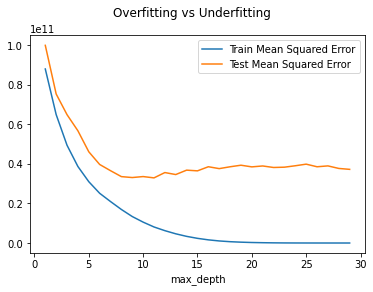

In [15]:
mod1["mse_train"].plot(label="Train Mean Squared Error")
mod1["mse_test"].plot(label="Test Mean Squared Error")
plt.suptitle("Overfitting vs Underfitting")
plt.legend()
plt.show();

Vemos que, para un número bajo de niveles, se tiene un alto error tanto para el subconjunto de entrenamiento como para el de *test*. Esto significa que los AD no son lo suficientemente complejos y existe *underfitting*. Por otra parte, a partir de aproximadamente 10 niveles, el error sobre el subconjunto de prueba alcanza un mínimo para después comenzar a oscilar y aumentar. Es decir, alcanzamos el valor óptimo en torno a 10 niveles, profundidad a partir de la cual encontramos *overfitting*, ya que el AD se ajusta demasiado al subconjunto de entrenamiento y no arroja buenas predicciones.

También podemos representar la bondad de ajuste de los modelos en función de su profundidad, llegando a un resultado análogo:

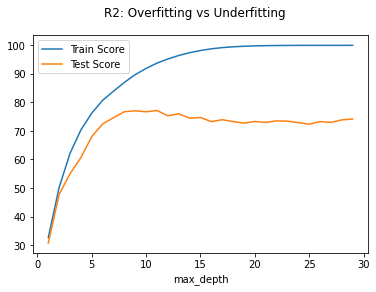

In [16]:
mod1["score_train"].plot(label="Train Score")
mod1["score_test"].plot(label="Test Score")
plt.suptitle("R2: Overfitting vs Underfitting")
plt.legend()
plt.show();

Aquí se observa que, para pocos niveles, el ajuste es malo en ambos subconjuntos, es decir, vemos de nuevo el *underfitting*. A partir de 10 niveles aproximadamente, el ajuste sobre el subconjunto de entrenamiento es muy bueno pero comienza a empeorar sobre el de *test*. Esto es, se tiene *overfitting*.

El número óptimo de niveles de profundidad lo elegimos filtrando por el máximo *score* obtenido para el subconjunto de *test*:

In [17]:
pd.DataFrame(mod1.loc[mod1['score_test'].idxmax(),:])

,11
score_train,9.378627e+01
score_test,7.717785e+01
mse_train,8.117988e+09
mse_test,3.294754e+10


Concluimos que una profundidad de **11 niveles** es la adecuada.

###Evaluación del modelo

Si generamos el modelo definitivo, con `max_depth=11`:

In [18]:
tree_model1 = DecisionTreeRegressor(random_state=0, max_depth=11)
tree_model1.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [19]:
pred_train = tree_model1.predict(X_train)
pred_test = tree_model1.predict(X_test)

In [20]:
r2_train_ad=100.0*tree_model1.score(X_train, y_train)
r2_test_ad=100.0*tree_model1.score(X_test, y_test)
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(r2_train_ad))
print("Precisión sobre los datos de test: {:.2f}".format(r2_test_ad))

Precisión sobre los datos de entrenamiento: 93.79
Precisión sobre los datos de test: 77.18


Se tiene una precisión del 77.18% sobre el subconjunto de *testing*.

Se pueden representar las variables que más contribuyen al modelo, de manera que:

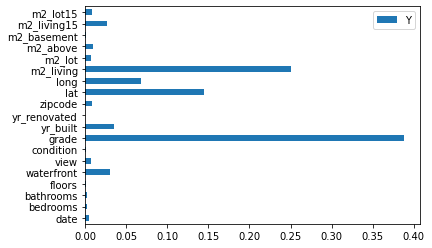

In [21]:
df_imp = pd.DataFrame(tree_model1.feature_importances_.reshape(1,-1), columns=X.columns, index=["Y"])
df_imp.T.plot.barh()
plt.legend()
plt.show();

Así, la variable más significativa es *grade*, lo cual tiene sentido pues contiene una calificación dada al inmueble que es directamente proporcional al valor del mismo. Le sigue la variable *m2_living*, que es el área total del inmueble. Tiene sentido que esta variable también contribuya mucho pues a mayor superficie, más caro suele ser un inmueble independientemente de su estado o características particulares. 

##*Random Forest*

El segundo algoritmo de predicción que vamos a implementar es un algoritmo ensamblado: *Random Forest*. En este tipo de algoritmo, se entrenan varios árboles de decisión en paralelo y se obtiene una predicción final calculada a partir de todas sus estimaciones. De esta forma se consigue reducir la variación y el *overfitting* del modelizado.

Se espera, por tanto, que las predicciones de este modelo sean mejores a las del árbol de decisión implementado previamente.

###Selección de *maxdepth*

De manera análoga al caso anterior, vamos a seleccionar el número óptimo de niveles de los árboles de decisión, de 1 a 20:

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [23]:
md_list = []
score_train_list = []
score_test_list = []

for maxdepth in list(range(1,20)):
  rf_model = RandomForestRegressor(random_state=0, max_depth=maxdepth, n_estimators=20, n_jobs=-1)
  rf_model.fit(X_train, y_train)

  ## Generación de listas
  md_list.append(maxdepth)
  score_train_list.append(100.0*rf_model.score(X_train, y_train))
  score_test_list.append(100.0*rf_model.score(X_test, y_test))

En este caso se han seleccionado `n_estimators=20`, es decir, 20 AD en paralelo en lugar de los 100 que se suelen lanzar por defecto, con el fin de no ralentizar demasiado la ejecución pues se trata de un *dataset* relativamente grande.

Si representamos la *accuracy* en función de la profundidad:

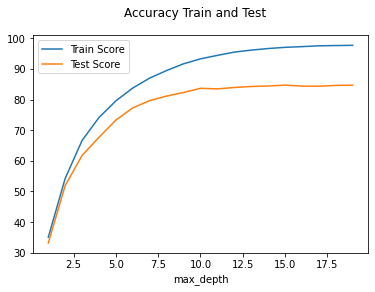

In [24]:
mod2 = pd.DataFrame({"max_depth":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list})

mod2.set_index("max_depth", inplace=True)
mod2["score_train"].plot(label="Train Score")
mod2["score_test"].plot(label="Test Score")
plt.suptitle("Accuracy Train and Test")
plt.legend()
plt.show();

De nuevo, observamos *underfitting* para profundidades muy bajas, debido a que los árboles de decisión no son lo suficientemente complejos para explicar adecuadamente el precio de los inmuebles del *dataset*. Asimismo, vemos que para aproximadamente 10 niveles de profundidad se llega a un máximo en la precisión del subconjunto de *test*, a partir de los cuales comienza a oscilar. Una profundidad superior estaría introduciendo una complejidad excesiva en los árboles de decisión, que conllevaría un mayor coste computacional sin suponer una mejora en las predicciones.

El valor definitivo se selecciona eligiendo el valor máximo para el subconjunto de *test*:

In [53]:
mod2[mod2.score_test==mod2.score_test.max()]

,score_train,score_test
max_depth,,
15,97.059175,84.709584


Por lo que nos quedamos con `max_depth=15`. Esta profundidad es superior a la seleccionada para el modelo anterior, es decir, los árboles son más complejos en esta modelización. Podría pensarse que este hecho va a causar *overfitting*, pues habíamos visto para el árbol de decisión que para más de 11 niveles de profundidad la *accuracy* no aumentaba para el subconjunto de *test*. Sin embargo, los algoritmos de *Random Forest* son mucho más robustos frente a sobreajustes debido a la gran cantidad de árboles de decisión en paralelo que se generan. Si existe sobreajuste en uno de los AD, se verá finalmente corregido por el resto de AD.

###Evaluación del modelo

Generamos el modelo que consideramos óptimo:

In [26]:
rf_model_15 = RandomForestRegressor(max_depth=15, n_estimators=20, random_state=0, n_jobs=-1)
rf_model_15.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [27]:
pred_train_rf = rf_model_15.predict(X_train)
pred_test_rf = rf_model_15.predict(X_test)

In [28]:
r2_train_rf=100.0*rf_model_15.score(X_train, y_train)
r2_test_rf=100.0*rf_model_15.score(X_test, y_test)
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(r2_train_rf))
print("Precisión sobre los datos de test: {:.2f}".format(r2_test_rf))

Precisión sobre los datos de entrenamiento: 97.06
Precisión sobre los datos de test: 84.71


Vemos que este modelo tiene una *accuracy* del 84.71% para el subconjunto de *test*, bastante superior a la que obtuvimos con únicamente un árbol de decisión, como era de esperar.

Por último, representamos las variables más importantes en el modelizado:

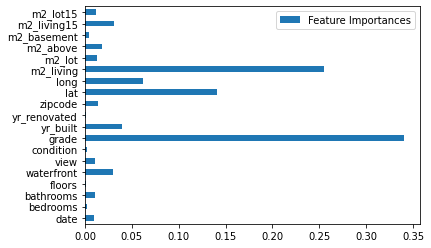

In [29]:
df_imp = pd.DataFrame(rf_model_15.feature_importances_.reshape(1,-1), columns=X.columns, index=["Feature Importances"])
df_imp.T.plot.barh()
plt.legend()
plt.show();

Comprobamos que la gráfica es casi idéntica a la que se obtuvo para el árbol de decisión, siendo de nuevo las variables más significativas *grade* y *m2_living*, aunque sí que se observa un mayor número de variables relevantes en esta segunda modelización (por ejemplo, *bathrooms*), probablemente debido a la selección aleatoria de variables que realiza este modelo en cada *split* de los AD.

##*Gradient Boosting*

El último algoritmo de predicción a implementar es otro algoritmo ensamblado: *Gradient Boosting*. En este caso, al igual que para el *Random Forest*, también se lanzan varios árboles de decisión, con la diferencia de que ahora se hace en serie en lugar de en paralelo. 

El objetivo es centrarse en los errores de la predicción de los árboles de decisión previos y tratar de mejorarlos en la siguiente modelización. Para ello, no es necesario generar árboles muy complejos, sino que basta con profundidades `max_depth<5`. De esta forma, nos aseguramos que los AD no se ajusten demasiado por sí solos a los datos sino que vayan aportando su grano de arena. Cada AD nos dará buenas predicciones en una parte pequeña de los datos, dando la posibilidad a los siguientes de ir mejorando la predicción del resto.

Es importante parametrizar adecuadamente el `learning_rate` del algoritmo. Este parámetro indica la "velocidad" a la que se acerca al mínimo de la función de coste, pues es el valor que queremos minimizar para obtener un modelo adecuado.

* **Si es un valor alto**: cada nuevo AD va a realizar correcciones más "fuertes" sobre los errores de los anteriores. El modelo se estaría haciendo más complejo en menos tiempo, con el consiguiente peligro de sobreajuste, sobre todo si se tienen muchos árboles de decisión.

* **Si es un valor muy pequeño**: las correcciones son menores y necesitaremos más AD para conseguir el ajuste deseado. Existe menos posibilidad de sobreajuste, incluso puede conllevar *underfitting* si no se tiene un número suficientemente grande de árboles de decisión.




###Modelo inicial

Vamos a realizar una parametrización sencilla inicial con 50 árboles de decisión con un único nivel de profundidad y `learning_rate=1`:

In [30]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [31]:
gb_model = GradientBoostingRegressor(random_state=0, n_estimators=50, max_depth=1, learning_rate=1)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1, loss='ls', max_depth=1,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [32]:
pred_test_gb = gb_model.predict(X_test)
pred_train_gb = gb_model.predict(X_train)

In [33]:
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*gb_model.score(X_train, y_train)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*gb_model.score(X_test, y_test)))

Precisión sobre los datos de entrenamiento: 80.71
Precisión sobre los datos de test: 75.04


La precisión de este modelo inicial es de un 80% sobre el subconjunto de entrenamiento y 75% sobre el de *test*. Vamos a tratar de optimizar los parámetros utilizados con el fin de mejorar la especificación del modelo.

###Selección del *max_depth*

En primer lugar, vamos a ver cómo se comporta la *accuracy* del modelo en función de la profundidad de los árboles de decisión. Como ya se ha argumentado, no se necesitan AD muy profundos, por lo que vamos a probar con 1, 2 y 3 niveles:

In [34]:
md_list = []
score_train_list = []
score_test_list = []

for maxdepth in list(range(1,4)):
  rf_model = GradientBoostingRegressor(random_state=0, max_depth=maxdepth, n_estimators=500)
  rf_model.fit(X_train, y_train)

  ## Generación de listas
  md_list.append(maxdepth)
  score_train_list.append(100.0*rf_model.score(X_train, y_train))
  score_test_list.append(100.0*rf_model.score(X_test, y_test))

Donde se han seleccionado 500 estimadores en serie. 

Representando la *accuracy* en función de `max_depth`:

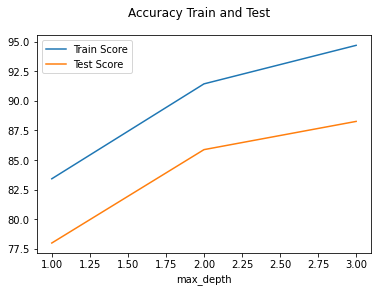

In [35]:
mod5 = pd.DataFrame({"max_depth":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list})

mod5.set_index("max_depth", inplace=True)
mod5["score_train"].plot(label="Train Score")
mod5["score_test"].plot(label="Test Score")
plt.suptitle("Accuracy Train and Test")
plt.legend()
plt.show();

Comprobamos que, a mayor profundidad, mejor es la *accuracy* tanto en el *set* de entrenamiento como en el de *test*. Esto se debe a que, para un único nivel, con los parámetros especificados, el algoritmo no consigue árboles lo suficientemente complejos por lo que habría que aumentar el número de AD si queremos evitar el *underfitting*.

Los valores concretos son:

In [36]:
mod5

,score_train,score_test
max_depth,,
1,83.411943,77.982532
2,91.434205,85.874757
3,94.690532,88.261482


###Selección del *learning rate*

Según hemos visto, el número adecuado de niveles por AD sería de `max_depth=3` si queremos evitar el *underfitting*. Sin embargo, el hecho de incluir árboles tan profundos ralentiza mucho la ejecución.

Vamos a proponer una alternativa, en la que buscamos llegar a un compromiso con un `max_depth=2` pero variando el *learning_rate* para ver si podemos mejorar la predicción de alguna forma.

Si iteramos para un `learning_rate` en el intervalo (0,1):

In [37]:
md_list = []
score_train_list = []
score_test_list = []

for lrate in list(range(1,10)):
  lrate=lrate/10
  rf_model = GradientBoostingRegressor(random_state=0, max_depth=2, n_estimators=500, learning_rate=lrate)
  rf_model.fit(X_train, y_train)

  ## Generación de listas
  md_list.append(lrate)
  score_train_list.append(100.0*rf_model.score(X_train, y_train))
  score_test_list.append(100.0*rf_model.score(X_test, y_test))

Procedemos a representar la precisión global de los modelos en función del *learning_rate*:

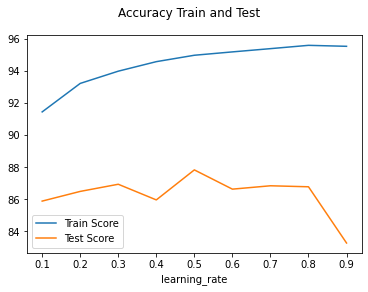

In [38]:
mod4 = pd.DataFrame({"learning_rate":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list})

mod4.set_index("learning_rate", inplace=True)
mod4["score_train"].plot(label="Train Score")
mod4["score_test"].plot(label="Test Score")
plt.suptitle("Accuracy Train and Test")
plt.legend()
plt.show();

Para valores del *learning_rate* bajos, tenemos *underfitting* pues tanto la *accuracy* del subconjunto de entrenamiento como la del subconjunto de *test* son bajas. Vemos que la mayor precisión sobre el *set* de *testing* se consigue para un `learning_rate=0.5`, parámetro para el cual se tienen resultados similares a los que llegábamos con un `max_depth=3`. Para valores superiores a 0.5, vemos cómo la precisión disminuye, es decir, se tiene *overfitting* y el algoritmo se está sobreajustando al *training set*. 

Así, concluimos que con árboles de decisión menos complejos (2 niveles en lugar de 3) podemos alcanzar la misma precisión si ralentizamos el *learning_rate* hasta 0.5 en vez de 1. 

Si redujéramos el número de árboles de decisión o seleccionásemos un único nivel de profundidad, probablemente veríamos cómo ya no existe *overfitting* para *learning_rates* en torno a 1, ya que se estaría perdiendo complejidad en los AD.

In [39]:
mod4[mod4.score_test==mod4.score_test.max()]

,score_train,score_test
learning_rate,,
0.5,94.965293,87.819533


La precisión sobre el subconjunto de *test* con esta parametrización es de 87,82%.

###Selección de n_estimators por parada temprana

Por último, vamos a utilizar el método denominado *parada temprana*, el cual consiste en computar los errores que arroja cada uno de los modelos y seleccionar aquel con un error menor gracias a la función `staged_predict()`. Para 500 AD, con los parámetros seleccionados previamente, creamos el modelo GB:

In [40]:
## Generación del modelo
gb_model = GradientBoostingRegressor(random_state=0, n_estimators=500, max_depth=2, learning_rate=0.5)
gb_model.fit(X_train, y_train)
pred_train_gb = gb_model.predict(X_train)
pred_test_gb = gb_model.predict(X_test)
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*gb_model.score(X_train, y_train)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*gb_model.score(X_test, y_test)))

Precisión sobre los datos de entrenamiento: 94.97
Precisión sobre los datos de test: 87.82


Calculamos los errores cuadráticos medios en las predicciones (subconjunto *test*):

In [41]:
errors = [mean_squared_error(y_test, y_pred) for y_pred in gb_model.staged_predict(X_test)]

Si representamos el error cuadrático medio en función del parámetro `n_estimators`, vemos que ocurre una reducción drástica desde 1 hasta 50 aproximadamente, número a partir del cual la pendiente se va suavizando. 

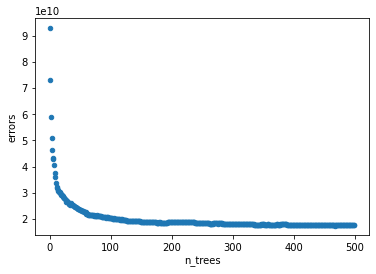

In [42]:
d = pd.DataFrame({"n_trees":list(range(500)), "errors":errors})
d.plot.scatter(x="n_trees", y= "errors")

Recuperamos el número de árboles de decisión que arrojan el mínimo para el error:

In [43]:
## el mejor número de AD nos lo da el índice donde MSE es menor
best_n_AD = np.argmin(errors)
best_n_AD

467

Así, no tenemos que llegar a los 500 árboles de decisión definidos previamente, pues con 467 conseguimos un error inferior. De esta manera, reduciendo el número de AD, también reducimos ligeramente el coste computacional de la implementación del algoritmo.

###Evaluación del modelo

Una vez conocemos una parametrización que consigue optimizar las predicciones del modelo, procedemos a generarlo:

In [44]:
best_model = GradientBoostingRegressor(random_state=0, n_estimators=best_n_AD, max_depth=2, learning_rate=0.5)
best_model.fit(X_train, y_train)
pred_train_gb = best_model.predict(X_train)
pred_test_gb = best_model.predict(X_test)
r2_train_gb=100.0*best_model.score(X_train, y_train)
r2_test_gb=100.0*best_model.score(X_test, y_test)

Nuestro modelo final tiene un 87.87% de precisión global sobre el subconjunto de prueba:

In [45]:
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(r2_train_gb))
print("Precisión sobre los datos de test: {:.2f}".format(r2_test_gb))

Precisión sobre los datos de entrenamiento: 94.85
Precisión sobre los datos de test: 87.87


Este resultado es superior al que alcanzamos con el algoritmo de *Random Forest*, aunque ha sido más difícil encontrar la parametrización adecuada.

Por último, comprobamos nuevamente cuáles son las variables más significativas:

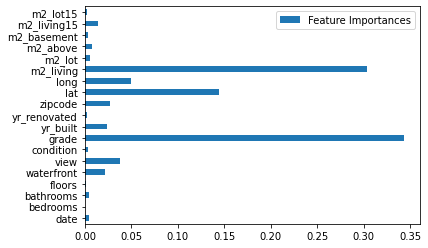

In [46]:
df_imp = pd.DataFrame(best_model.feature_importances_.reshape(1,-1), columns=X.columns, index=["Feature Importances"])
df_imp.T.plot.barh()
plt.legend()
plt.show();

Al igual que para los dos algoritmo previos, las variables más importantes vuelven a ser *grade* y *m2_living*. Esto tiene sentido pues, si representamos la matriz de correlación de las variables del *set* de datos, vemos que las que mayor correlación presentan con el precio son *m2_living* (70%) y *grade* (67%):

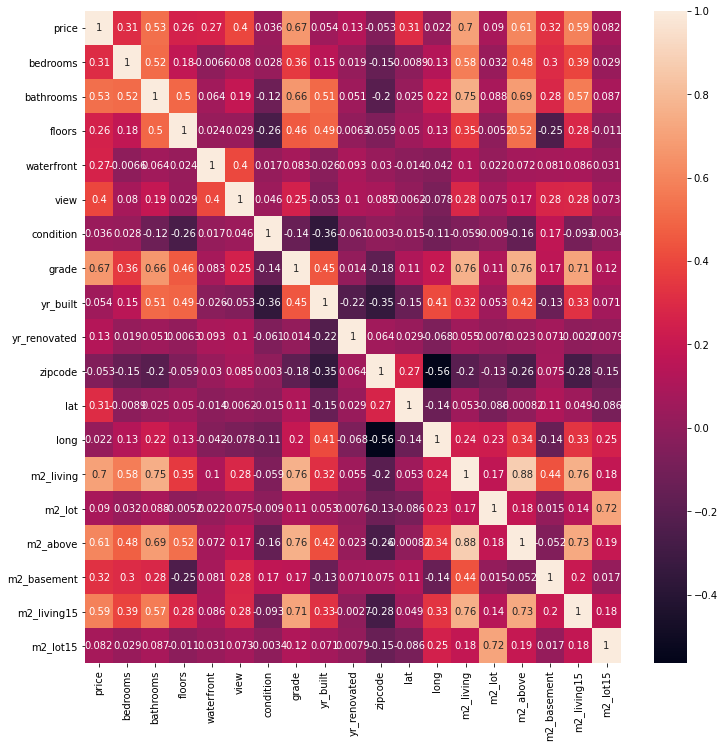

In [47]:
import seaborn as sn
fig, ax = plt.subplots(figsize=(12,12)) 
sn.heatmap(df.corr(), annot=True)

#Comparativa entre modelos

A continuación procedemos a comparar los tres algoritmos aplicados sobre el *dataset* en función del error cuadrático medio, el error total y la bondad de ajuste $R^2$.

- Error cuadrático medio (*Mean squared error o mse*):

In [48]:
from sklearn.metrics import mean_squared_error
print ("AD:", mean_squared_error(y_test, pred_test))
print ("RF:", mean_squared_error(y_test, pred_test_rf))
print ("GB:", mean_squared_error(y_test, pred_test_gb))

AD: 32947541077.326805
RF: 22074242732.8393
GB: 17507830999.424458


El error cuadrático medio es más alto para el árbol de decisión, mientras que se reduce casi a la mitad en el algoritmo de *Gradient Boosting*.

- Error total:

In [49]:
from sklearn.metrics import mean_absolute_error
print ("AD:", mean_absolute_error(y_test, pred_test))
print ("RF:", mean_absolute_error(y_test, pred_test_rf))
print ("GB:", mean_absolute_error(y_test, pred_test_gb))

AD: 92498.37040296166
RF: 76190.85465409572
GB: 72915.07918095533


De manera análoga, el error absoluto es mayor para el árbol de decisión, disminuye para el *Random Forest* y es más bajo para el *Gradient Boosting*.

- $R^2$:

In [50]:
print("AD: Precisión entrenamiento: {:.2f}".format(r2_train_ad))
print("AD: Precisión test: {:.2f}".format(r2_test_ad))

AD: Precisión entrenamiento: 93.79
AD: Precisión test: 77.18


In [51]:
print("RF: Precisión entrenamiento: {:.2f}".format(r2_train_rf))
print("RF: Precisión test: {:.2f}".format(r2_test_rf))

RF: Precisión entrenamiento: 97.06
RF: Precisión test: 84.71


In [52]:
print("GB: Precisión entrenamiento: {:.2f}".format(r2_train_gb))
print("GB: Precisión test: {:.2f}".format(r2_test_gb))

GB: Precisión entrenamiento: 94.85
GB: Precisión test: 87.87


En resumen:

|          Modelo        | $R^2$ *training* (%) |  $R^2$ *test* (%) | 
|------------------------|:--------------------:|:-----------------:|
|   Árbol de decisión    |         93.8         |          77.2     |      
|   *Random Forest*      |         97.1         |          84.7     |
|   *Gradient Boosting*  |         94.9         |         87.9      |      
 

Vemos que existe un salto del 10.7% en la precisión sobre el subconjunto de *test* entre el árbol de decisión y el *Gradient Boosting*. Se trata de una mejora significativa, pero a costa de un gran consumo de recursos computacionales y un aumento considerable de los tiempos de ejecución.

#Conclusiones

Los algoritmos ensamblados son los claros ganadores en el modelizado del precio de los inmuebles, pues ambos consiguen mejorar las predicciones con respecto al árbol de decisión. Sin embargo, al ser más complejos, sus resultados son más difíciles de interpretar, por lo que si buscamos conocer la explicabilidad de la variable dependiente tiene sentido comenzar con un único árbol de decisión.

Por su parte, la diferencia entre los dos algoritmos ensamblados *Random Forest* y *Gradient Boosting* no es muy marcada, siendo este último el que consigue realizar mejores predicciones. Sin embargo, el *fine tunning* necesario para lograr unos buenos resultados en el algoritmo de *Gradient Boosting* hace que sea menos atractivo a la hora de ser implementado, ya que el modelo de *Random Forest* es mucho menos susceptible a caer en el *overfitting*.

En conclusión, si lo que queremos es la máxima precisión posible en las predicciones sobre el subconjunto de *testing*, debemos elegir el algoritmo *Gradient Boosting*. Sin embargo, hay que tener cuidado a la hora de elegir una parametrización adecuada (ha sido necesario ajustar 3 parámetros), pues es fácil caer tanto en *underfitting* (con árboles poco profundos, un *learning rate* bajo y/o muy pocos AD) como en *overfitting* (*learning rate* muy alto y muchos AD), como ya hemos argumentado. Además, los tiempos de ejecución son muy altos ya que no se puede paralelizar el proceso, por lo que no pueden generarse árboles muy complejos.

Si, por el contrario, queremos un modelizado con menos *fine tunning*, que funcione bien sin tener que afinar mucho la parametrización, entonces elegiremos el *Random Forest*. Esta modelización arroja predicciones sensiblemente menos precisas pero es más fácil de implementar. Además, como ya se ha comentado, tiene la ventaja de ser bastante robusta ante *overfitting* incluso para un número no excesivamente elevado de AD (20 en este caso).
    